## Corporate Credit Rating Prediction

The purpose of this notebook is to build a machine learning model from credit rating data that can be used to predict the rating a company will receive.

The first section loads the pre-processed data and defines a training, validation and test set. A second section fits a number of ML algorithms and the performance of each model is compared by calculating the F1 Score on the validation set. The best performing model is taken forward for further refinement.

Hyperparameter tuning is applied on the validation set to find the optimal set of hyperparameters. The model is retrained with the new set of parameters and applied to the test set. A number of evaluation techniques such as a confusion metrics and F1 score are used to understand the model performance. Finally, feature selection is performed to understand the most important financial indicators for predicting corporate credit ratings. 


### Imports and Loading Dataset

In [1]:
# Import libraries

import sys
import numpy as np
import pandas as pd
import time

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from math import sqrt

import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import seaborn as sns

sys.path.append('/Users/bethbarlow/Documents/Nanodegree/udacity_ds_nanodegree_capstone')

from utils.helpers import fit_model_get_results, plot_feature_importances

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None) 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
X = pd.read_csv('/Users/bethbarlow/Documents/Nanodegree/udacity_ds_nanodegree_capstone/data/features_preproc.csv')
y = pd.read_csv('/Users/bethbarlow/Documents/Nanodegree/udacity_ds_nanodegree_capstone/data/target_preproc.csv')

# Remove unnamed columns
X = X.drop(columns = 'Unnamed: 0').head(-3)
y = y.drop(columns = 'Unnamed: 0').head(-3)

# Convert to flattened array
y = np.ravel(y)

Split the our input and output data into training, validation and testing data, so as to train the model on the training data and test the model's performance on the validation and test data. We choose a 70%–20%-10% split for our training, validation and testing data.

In [3]:
# Define numerical and categorical columns
numerical_ix = X.iloc[:, 0:25].columns.tolist()
categorical_ix = ['Rating Agency Name', 'Sector']

# Define train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True, stratify = y)

# Tune scaler on train set and apply tuned scaler to test set
scaler = MinMaxScaler()
X_train[numerical_ix] = scaler.fit_transform(X_train[numerical_ix])
X_test[numerical_ix] = scaler.transform(X_test[numerical_ix])

# Split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.22, stratify = y_train)

# Check shape of feature dataframes
print('The training set contains', X_train.shape[0], 'rows and', X_train.shape[1], 'columns')
print('The validation set contains', X_val.shape[0], 'rows and', X_val.shape[1], 'columns')
print('The test set contains', X_test.shape[0], 'rows and', X_test.shape[1], 'columns')

The training set contains 1421 rows and 42 columns
The validation set contains 402 rows and 42 columns
The test set contains 203 rows and 42 columns


### Fit Baseline Models

Use built-in algorithms from sci-kit learn to train models. 

In [5]:
# Define features list
features = X.columns.tolist()
np.random.seed(1)

In [6]:
# Fit Multinomial Logistic Regression model
lr = LogisticRegression(multi_class='multinomial', max_iter = 20000)

lr_results = fit_model_get_results(lr, features, X_train, y_train, X_val, y_val)
lr_results

{'classifier': LogisticRegression(max_iter=20000, multi_class='multinomial'),
 'train_f1': 0.39657983315341966,
 'val_f1': 0.34701555973955456,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [7]:
# Fit Random Forest model
rf = RandomForestClassifier(n_estimators = 10)
rf_results = fit_model_get_results(rf, features, X_train, y_train, X_val, y_val)
rf_results

{'classifier': RandomForestClassifier(n_estimators=10),
 'train_f1': 0.9901673823835312,
 'val_f1': 0.49625377158494016,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [8]:
# Fit K Nearest Neighbours model
knn = KNeighborsClassifier()
knn_results = fit_model_get_results(knn, features, X_train, y_train, X_val, y_val)
knn_results

{'classifier': KNeighborsClassifier(),
 'train_f1': 0.5308868833580576,
 'val_f1': 0.34217954927389715,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [9]:
# Fit Naive Bayes model
gnb = GaussianNB()

gnb_results = fit_model_get_results(gnb, features, X_train, y_train, X_val, y_val)
gnb_results

{'classifier': GaussianNB(),
 'train_f1': 0.09029013867001962,
 'val_f1': 0.06585696022310017,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [10]:
# Fit XGBoost model 
xgb = XGBClassifier('multi:softmax')
xgb_results = fit_model_get_results(xgb, features, X_train, y_train, X_val, y_val)
xgb_results

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='multi:softmax', predictor=None, ...),
 'train_f1': 1.0,
 'val_f1': 0.5884657970837113,
 'training_execution_time': 2.0,
 'prediction_execution_time': 0.0}

In [11]:
# Get F1 scores from each fitted model
train_f1_list = [lr_results['train_f1'], rf_results['train_f1'], knn_results['train_f1'], gnb_results['train_f1'], xgb_results['train_f1']]
val_f1_list = [lr_results['val_f1'], rf_results['val_f1'], knn_results['val_f1'], gnb_results['val_f1'], xgb_results['val_f1']]

model_list = ['Multinomial Logistic Regression', 'Random Forest','KNN', 'Naive Bayes', 'XGBoost']

df_f1 = pd.DataFrame({'Model': model_list, 'Validation F1 Score': val_f1_list, 'Train F1 Score': train_f1_list})

order = list(df_f1.sort_values('Validation F1 Score', ascending=False).Model)
df_f1 = df_f1.sort_values('Validation F1 Score', ascending=False).reset_index().drop(['index'], axis=1)

                             Model             Variable     Value
3                              KNN  Validation F1 Score  0.342180
8                              KNN       Train F1 Score  0.530887
2  Multinomial Logistic Regression  Validation F1 Score  0.347016
7  Multinomial Logistic Regression       Train F1 Score  0.396580
4                      Naive Bayes  Validation F1 Score  0.065857
9                      Naive Bayes       Train F1 Score  0.090290
1                    Random Forest  Validation F1 Score  0.496254
6                    Random Forest       Train F1 Score  0.990167
0                          XGBoost  Validation F1 Score  0.588466
5                          XGBoost       Train F1 Score  1.000000


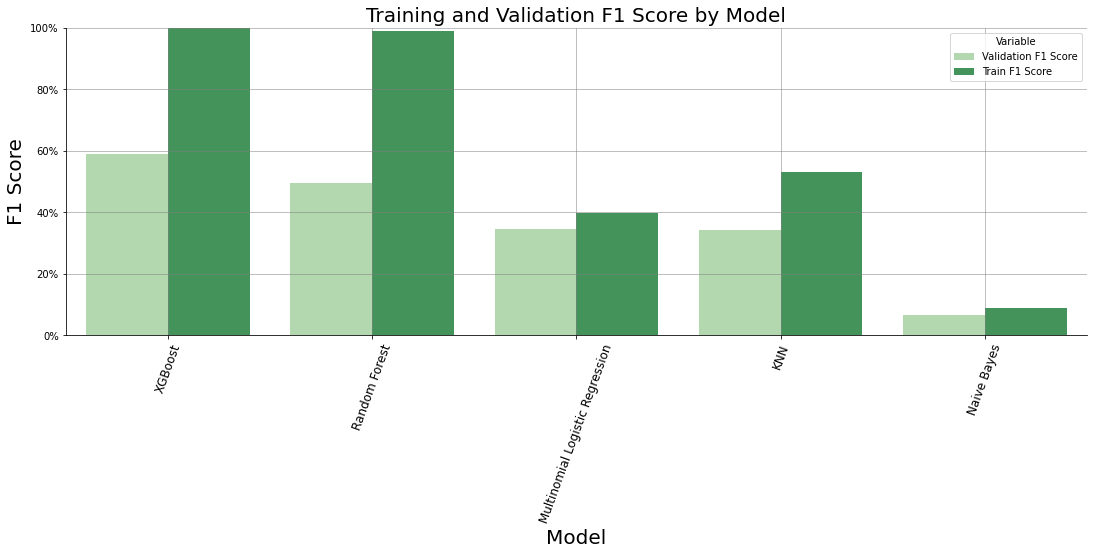

In [12]:
# Plot F1 Scores for each model on validation and training set

fig, ax1 = plt.subplots(figsize=(15, 5))
tidy = df_f1.melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy, ax=ax1, palette = 'Greens')
sns.despine(fig)
plt.tight_layout()
plt.xlabel("Model", fontsize=20)
plt.ylabel("F1 Score", fontsize=20)
plt.title("Training and Validation F1 Score by Model", fontsize=20)
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.xticks(rotation=70, fontsize=12)
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

print(tidy.sort_values('Model'))

XGBoost and Random Forest algorithms display large differences in training and validation accuracy. This indicates overfitting. 

If a model is overtrained or too complex, high variance will be observed. If a model is too inflexible and produces similar errors in both training and testing data, high bias will be observed.

### Hyperparameter tuning on validation set

The performance of the XGBoost model can be improved by hyperparameter tuning using Optuna.

Create objective function to be passed to the study.optimize function. The objective function will take the trial parameter, which is an instance of the Trial class, and will return the F1-score associated with the trial.

In [14]:
def objective(trial,
             X,
             y,
             sampler,
             n_splits):
    
    """
    Defines objective function for optuna to maximise.
    Takes a trial object as input and returns f1-score.
    """

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 600, 50),
        'eta': trial.suggest_float('eta', 0, 1),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'subsample': trial.suggest_float('subsample', 0, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
    }
    
    clf = XGBClassifier(**params)
    
    skf = StratifiedKFold(n_splits=n_splits)
    lst_f1_stratified = []
        
    start_time = time.time()

    X_values = X.values

    for train_index, test_index in skf.split(X_values, y):
    
        X_train_fold, X_test_fold = X_values[train_index], X_values[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        
        if sampler == 'None':
            X_train_fold_res, y_train_fold_res = X_train_fold, y_train_fold
        else:
            X_train_fold_res, y_train_fold_res = sampler.fit_resample(X_train_fold, y_train_fold)
        
        clf.fit(X_train_fold_res, y_train_fold_res)
        preds = np.rint(clf.predict(X_test_fold))
        
        f1 = metrics.f1_score(y_test_fold, preds, average = 'weighted')
        
        lst_f1_stratified.append(f1)
    
        training_execution_time = time.time() - start_time
        
    f1_mean = np.mean(lst_f1_stratified)

    return f1_mean

For each resampling technique, define an Optuna study. Use 5-fold cross validation; for each fold, run the objective function using the study.optimize function. Set the n_trials parameter to 50 (Optuna runs the objective function 50 times to find best hyperparameters). 

Sampler: None

Best score: 0.5310532593207661

Optimized parameters: {'max_depth': 8, 'n_estimators': 400, 'eta': 0.09860320469273205, 'gamma': 0.038378995161902935, 'subsample': 0.6673019646162675, 'colsample_bytree': 0.8749660641256987, 'reg_alpha': 0.6123959265237534, 'reg_lambda': 0.20303066320725047}

Number of finished trials: 50
    max_depth: 8
    n_estimators: 400
    eta: 0.09860320469273205
    gamma: 0.038378995161902935
    subsample: 0.6673019646162675
    colsample_bytree: 0.8749660641256987
    reg_alpha: 0.6123959265237534
    reg_lambda: 0.20303066320725047


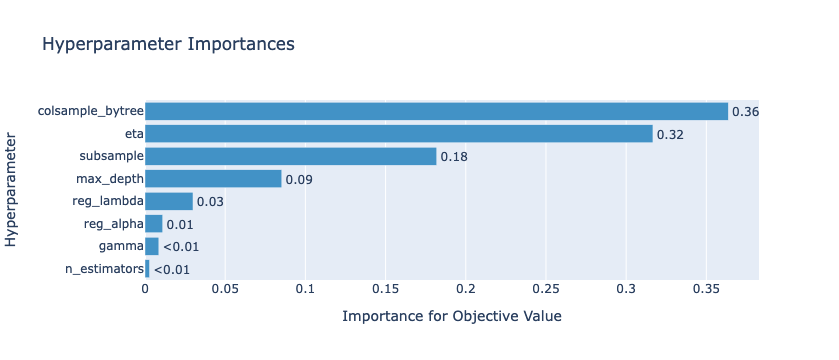

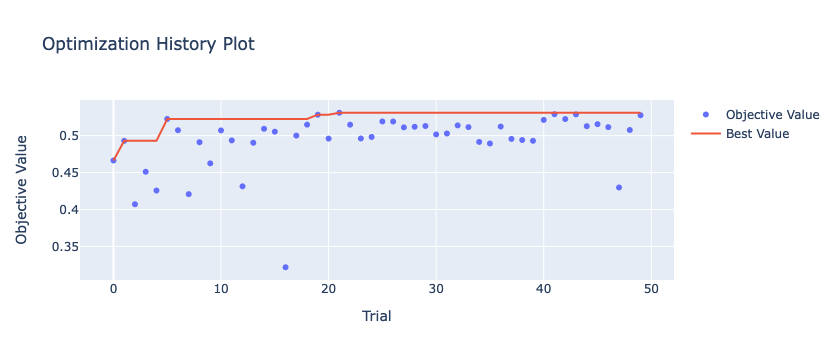

Sampler: RandomUnderSampler

Best score: 0.36655470990656547

Optimized parameters: {'max_depth': 7, 'n_estimators': 550, 'eta': 0.012597327632011712, 'gamma': 0.1350268210205262, 'subsample': 0.953923226905159, 'colsample_bytree': 0.2793331656089445, 'reg_alpha': 0.4175342758614018, 'reg_lambda': 0.2980421193494581}

Number of finished trials: 50
    max_depth: 7
    n_estimators: 550
    eta: 0.012597327632011712
    gamma: 0.1350268210205262
    subsample: 0.953923226905159
    colsample_bytree: 0.2793331656089445
    reg_alpha: 0.4175342758614018
    reg_lambda: 0.2980421193494581


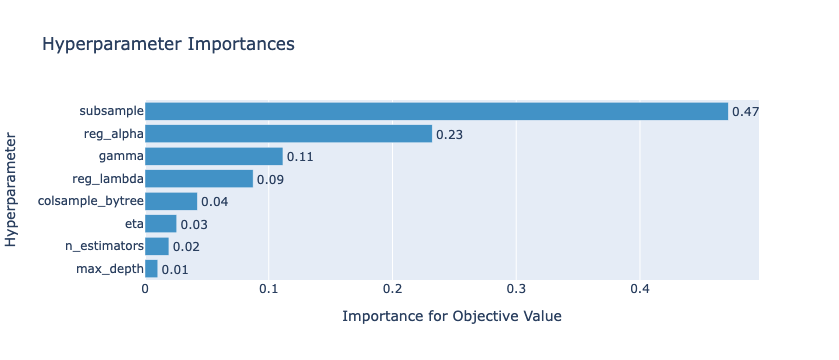

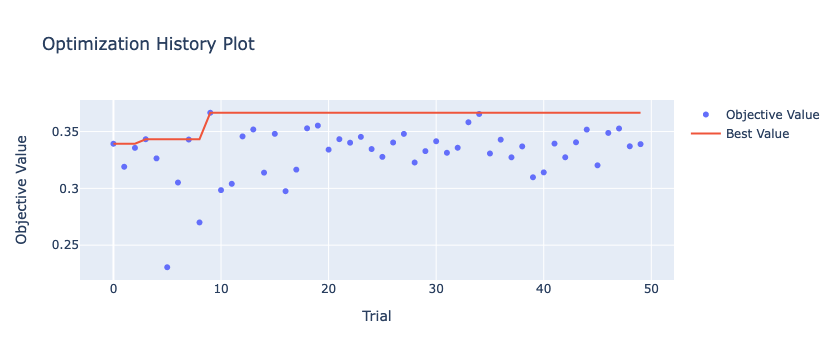

Sampler: RandomOverSampler

Best score: 0.5347953825794812

Optimized parameters: {'max_depth': 7, 'n_estimators': 300, 'eta': 0.07211077129241486, 'gamma': 0.06462288809847885, 'subsample': 0.7907459887880808, 'colsample_bytree': 0.6143382176315698, 'reg_alpha': 0.32362436244976384, 'reg_lambda': 0.7309082608142007}

Number of finished trials: 50
    max_depth: 7
    n_estimators: 300
    eta: 0.07211077129241486
    gamma: 0.06462288809847885
    subsample: 0.7907459887880808
    colsample_bytree: 0.6143382176315698
    reg_alpha: 0.32362436244976384
    reg_lambda: 0.7309082608142007


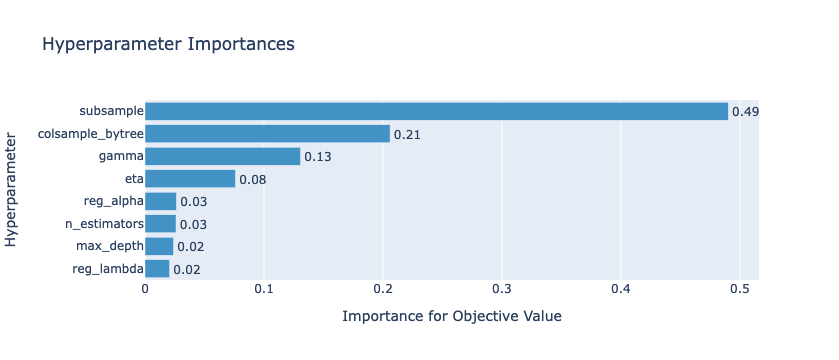

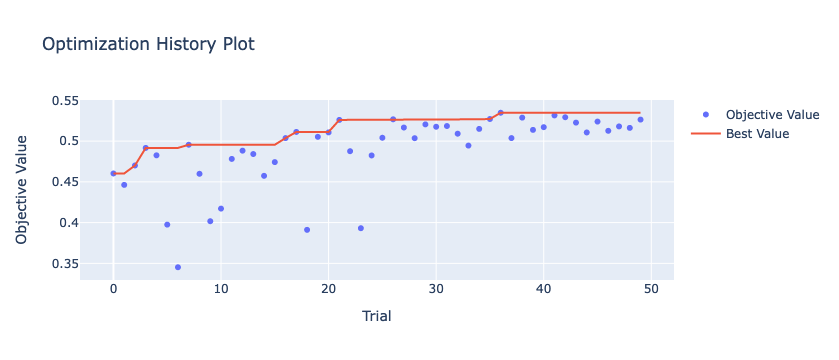

Sampler: SMOTE

Best score: 0.5189365181929622

Optimized parameters: {'max_depth': 9, 'n_estimators': 450, 'eta': 0.11211624549947179, 'gamma': 0.3877969341459817, 'subsample': 0.6713436671804262, 'colsample_bytree': 0.5878689371510991, 'reg_alpha': 0.4774716553566396, 'reg_lambda': 0.1844873104163657}

Number of finished trials: 50
    max_depth: 9
    n_estimators: 450
    eta: 0.11211624549947179
    gamma: 0.3877969341459817
    subsample: 0.6713436671804262
    colsample_bytree: 0.5878689371510991
    reg_alpha: 0.4774716553566396
    reg_lambda: 0.1844873104163657


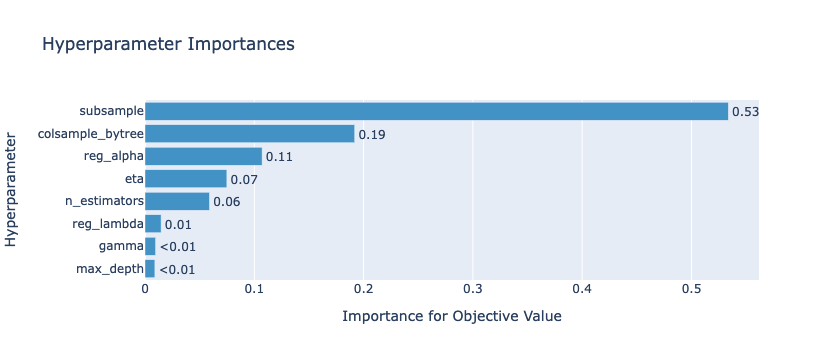

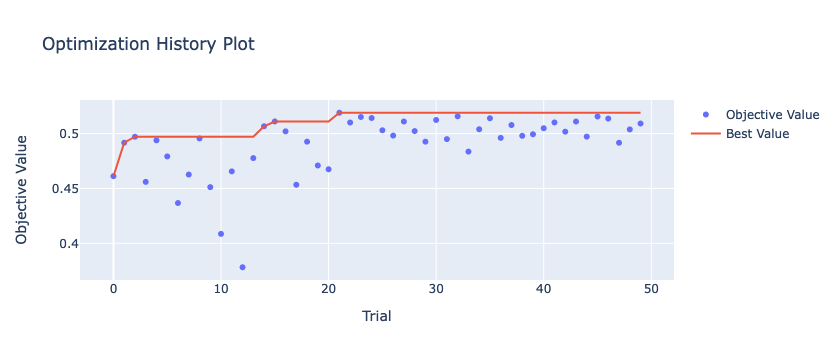

In [17]:
# Initialise
np.random.seed(123)
start_time = time.time()
sampler_types = ["None", "RandomUnderSampler", "RandomOverSampler", "SMOTE"]
optim_results = {}
best_params = {}
        
# Loop over sampling types:
for sampler_type in sampler_types:

    # Optimise parameters for all three samplers. Set direction to maximise to maximise F1-score
    study = optuna.create_study(direction = 'maximize')
    
    if sampler_type == "None":
        sampler = sampler_type
    else:
        sampler = eval(sampler_type)()
    
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, sampler, n_splits = 5),
        n_trials=50,
        n_jobs=1,
    )
        
    best_params = study.best_params
    best_score = study.best_value
    print(f"Sampler: {sampler_type}\n")
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {best_params}\n")

    print("Number of finished trials:", len(study.trials))

    trial = study.best_trial
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    best_params[sampler_type] = trial.params
    optim_results[sampler_type] = study
    plot_param_importances(study).show()
    plot_optimization_history(study).show()

optimisation_time = time.time() - start_time

In [18]:
# Produce summary of hyperparameter tuning

tuning_summary = pd.DataFrame(columns = 
                               ["Sampler",
                               "Trial",
                               "f1-score",
                               "Parameters"])

for sampler, study in optim_results.items():
    
    tuning_summary.loc[len(tuning_summary.index)] = [
        sampler,
        int(study.best_trial.number),
        study.best_trial.values[0],
        study.best_trial.params,
    ]

    tuning_summary['Trial'] = tuning_summary['Trial'].astype(int)
                            
time_taken = optimisation_time/60
tuning_summary = tuning_summary.round(4) 
tuning_summary, time_taken

(              Sampler  Trial  f1-score  \
 0                None     21    0.5311   
 1  RandomUnderSampler      9    0.3666   
 2   RandomOverSampler     36    0.5348   
 3               SMOTE     21    0.5189   
 
                                                                                                                                                                                                                                       Parameters  
 0  {'max_depth': 8, 'n_estimators': 400, 'eta': 0.09860320469273205, 'gamma': 0.038378995161902935, 'subsample': 0.6673019646162675, 'colsample_bytree': 0.8749660641256987, 'reg_alpha': 0.6123959265237534, 'reg_lambda': 0.20303066320725047}  
 1     {'max_depth': 7, 'n_estimators': 550, 'eta': 0.012597327632011712, 'gamma': 0.1350268210205262, 'subsample': 0.953923226905159, 'colsample_bytree': 0.2793331656089445, 'reg_alpha': 0.4175342758614018, 'reg_lambda': 0.2980421193494581}  
 2   {'max_depth': 7, 'n_estimators': 300, 'eta': 0

The best parameters for each resampling technique are saved in a dictionary and passed to the XGBoost Classifier to retrain model with the optimal hyperparameter set.

In [19]:
# Combine train and validation sets to train model on full training set
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = np.append(y_train, y_val)

In [20]:
# Re-train XGBoost model with best performing sampling technique and tuned hyperparameters

# Initialise
np.random.seed(1)
sampler = 'RandomOverSampler'
tuned_params = dict(zip(tuning_summary.Sampler, tuning_summary.Parameters))

# Fit model and get predictions and f1 score
model_name = "{} + XGBoost".format(sampler)

clf = XGBClassifier(**tuned_params[sampler])

sampler = eval(sampler)()

# Get a new sample
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

# Fit model
clf.fit(X_train_res, y_train_res)

# Get predictions on test set
test_predictions = clf.predict(X_test)
train_predictions = clf.predict(X_train_res)

# Get f1 score
f1_test = f1_score(y_test, test_predictions, average = 'weighted')
f1_train = f1_score(y_train_res, train_predictions, average = 'weighted')

model = clf
print("The model produces a Train F1 score of", f1_train, "and a Test F1 Score of", f1_test)

The model produces a Train F1 score of 1.0 and a Test F1 Score of 0.5362672234377003


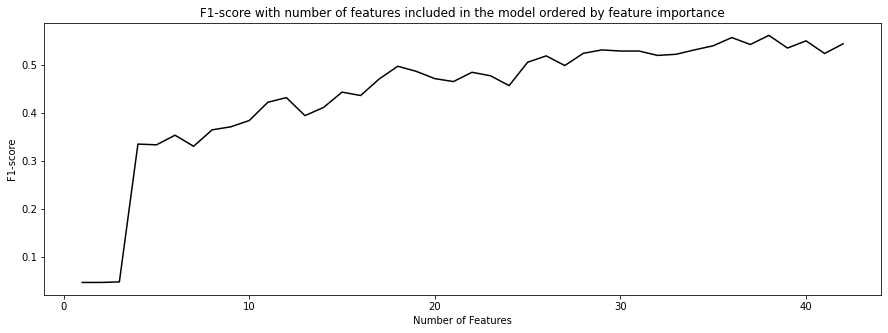

In [28]:
# Fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)
n_params = []
f1_scores = []

for thresh in thresholds:
    
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_res)
    n_params.append(select_X_train.shape[1])
    
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train_res)
    
    # evaluate model
    select_X_test = selection.transform(X_test)
    preds = selection_model.predict(select_X_test)
    preds_round = [round(value) for value in preds]
    
    f1 = f1_score(y_test, preds, average = 'weighted')
    f1_scores.append(f1)
    
# Plot    
fig, ax = plt.subplots(figsize=(15, 5))
fig = sns.lineplot(x = n_params, y = f1_scores, color = 'black')
plt.xlabel("Number of Features")
plt.ylabel("F1-score")
plt.title("F1-score with number of features included in the model ordered by feature importance")
plt.show()

Use the same evaluation techniques as before, assessing performance with the f1-score function, and the classification_report function

,precision,recall,f1-score,support
A,0.62,0.70,0.66,40.00
AAA/AA,0.43,0.30,0.35,10.00
B,0.34,0.33,0.34,30.00
BB,0.56,0.47,0.51,49.00
BBB,0.61,0.67,0.64,67.00
CCC and below,0.14,0.14,0.14,7.00
accuracy,0.54,0.54,0.54,0.54
macro avg,0.45,0.44,0.44,203.00
weighted avg,0.54,0.54,0.54,203.00


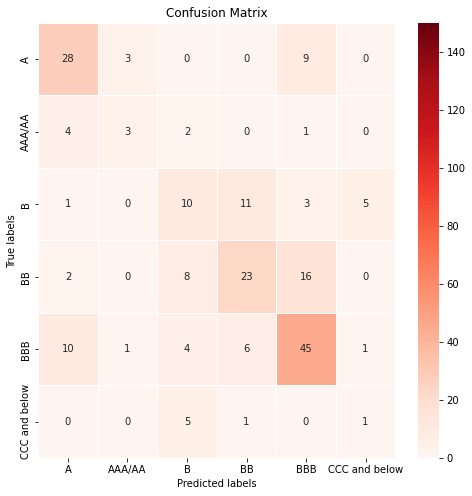

In [21]:
# Display classification report and confusion matrix

labels = ['A', 'AAA/AA', 'B', 'BB', 'BBB', 'CCC and below']

y_pred = model.predict(X_test)
report_dict = metrics.classification_report(y_test, y_pred, output_dict = True, 
                                            target_names = labels)
cm = confusion_matrix(y_test, y_pred)                                                                                           

display(pd.DataFrame(report_dict).T.round(decimals = 2))

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cm, 
            annot = True, 
            ax = ax, 
            vmin=0, 
            vmax=150, 
            fmt="d", 
            linewidths=.5, 
            linecolor = 'white', 
            cmap="Reds",
           xticklabels = labels,
           yticklabels = labels)


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

plt.show()

Better to predict lower and achieve higher rating than the other way around. Looking for low numbers in the bottom left corner of the confusion matrix.

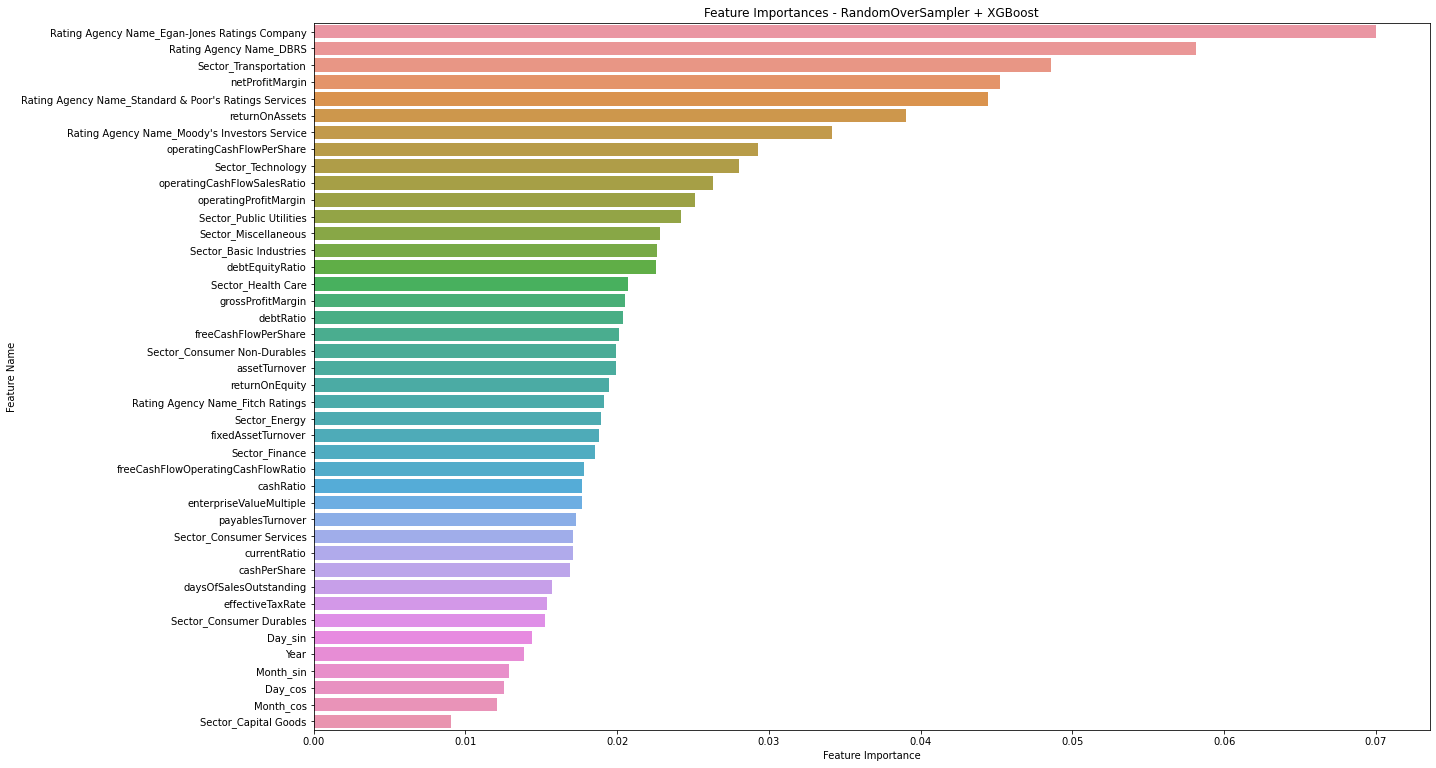

In [22]:
# Plot feature importances
plot_feature_importances(model = model, title = 'RandomOverSampler + XGBoost', features = features)